In [ ]:
%pip install scikit-learn
%pip install seaborn
%pip install plotly
%pip install shap
%pip install statsmodels


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
import numpy as np 

In [ ]:
file_path = 'Mental_Health_Care_in_the_Last_4_Weeks.csv'
df = pd.read_csv(file_path)

df.info()
df.head()

print(df.columns.tolist())

columns_to_keep = [
    'Indicator', 'Group', 'Subgroup', 'Time Period', 'Value'
]
df_reduced = df[columns_to_keep].copy()

df_reduced.dropna(subset=['Value'], inplace=True)

pivot_df = df_reduced.pivot_table(
    index=['Group', 'Subgroup'],
    columns='Indicator',
    values='Value',
    aggfunc='mean' 
).reset_index()

pivot_df.fillna(pivot_df.mean(numeric_only=True), inplace=True)

subgroup_labels = pivot_df[['Group', 'Subgroup']]

features = pivot_df.drop(columns=['Group', 'Subgroup'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10404 entries, 0 to 10403
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Indicator               10404 non-null  object 
 1   Group                   10404 non-null  object 
 2   State                   10404 non-null  object 
 3   Subgroup                10404 non-null  object 
 4   Phase                   10404 non-null  object 
 5   Time Period             10404 non-null  int64  
 6   Time Period Label       10404 non-null  object 
 7   Time Period Start Date  10404 non-null  object 
 8   Time Period End Date    10404 non-null  object 
 9   Value                   9914 non-null   float64
 10  LowCI                   9914 non-null   float64
 11  HighCI                  9914 non-null   float64
 12  Confidence Interval     9914 non-null   object 
 13  Quartile Range          6732 non-null   object 
 14  Suppression Flag        22 non-null   

In [ ]:
df_snapshot = df[
    (df['Phase'].str.contains('3')) & (df['Time Period Label'] == 'Dec 9 - Dec 21, 2020')
].copy()
print(df_snapshot['Group'].unique())
print("Rows:", df_snapshot.shape)
print("Missing Value count:", df_snapshot['Value'].isnull().sum())

['National Estimate' 'By Age' 'By Sex'
 'By Presence of Symptoms of Anxiety/Depression'
 'By Race/Hispanic ethnicity' 'By Education' 'By State']
Rows: (288, 15)
Missing Value count: 0


In [ ]:
df_pivot = df_snapshot.pivot(index=['Group','Subgroup'], 
                             columns='Indicator', values='Value')
df_pivot = df_pivot.reset_index()
df_pivot.head(6)

Indicator,Group,Subgroup,"Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks","Received Counseling or Therapy, Last 4 Weeks","Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks","Took Prescription Medication for Mental Health, Last 4 Weeks"
0,By Age,18 - 29 years,22.1,12.7,24.9,19.9
1,By Age,30 - 39 years,17.2,15.3,27.7,22.1
2,By Age,40 - 49 years,13.8,11.4,26.0,22.2
3,By Age,50 - 59 years,10.4,9.9,26.5,23.6
4,By Age,60 - 69 years,6.0,5.8,23.8,22.4
5,By Age,70 - 79 years,4.4,4.3,21.0,19.6


In [ ]:
age_table = df_pivot[df_pivot['Group']=="By Age"].set_index('Subgroup')
age_table[['Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks']].rename(
    columns={'Took Prescription Medication And/Or Therapy, Last 4 Weeks': 'Combined Care (%)'}) \
    .T

X = df_pivot[['Took Prescription Medication for Mental Health, Last 4 Weeks',
              'Received Counseling or Therapy, Last 4 Weeks',
              'Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks']]
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
df_pivot['Cluster'] = kmeans.labels_
print(df_pivot[['Group','Subgroup','Cluster']].head(8))

X = df_pivot[['Took Prescription Medication for Mental Health, Last 4 Weeks',
              'Received Counseling or Therapy, Last 4 Weeks',
              'Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks']].fillna(0)
y = (df_pivot['Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks'] >= df_pivot['Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks'].median()).astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Logistic accuracy:", accuracy_score(y_test, y_pred))
print("Coefficients:")
for name, coef in zip(X.columns, logreg.coef_[0]):
    print(f"  {name}: {coef:.3f}")

rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
print("RF accuracy:", accuracy_score(y_test, rf.predict(X_test)))
importances = rf.feature_importances_
print("Feature importances:")
for name, imp in zip(X.columns, importances):
    print(f"  {name}: {imp:.3f}")


Indicator         Group                     Subgroup  Cluster
0                By Age                18 - 29 years        0
1                By Age                30 - 39 years        0
2                By Age                40 - 49 years        0
3                By Age                50 - 59 years        2
4                By Age                60 - 69 years        1
5                By Age                70 - 79 years        1
6                By Age           80 years and above        1
7          By Education  Bachelor's degree or higher        0
Logistic accuracy: 1.0
Coefficients:
  Took Prescription Medication for Mental Health, Last 4 Weeks: 1.509
  Received Counseling or Therapy, Last 4 Weeks: 0.768
  Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks: -0.214
RF accuracy: 0.9444444444444444
Feature importances:
  Took Prescription Medication for Mental Health, Last 4 Weeks: 0.596
  Received Counseling or Therapy, Last 4 Weeks: 0.245
  Needed Counseling or Therapy B

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(pca_components)

result_df = subgroup_labels.copy()
result_df['PC1'] = pca_components[:, 0]
result_df['PC2'] = pca_components[:, 1]
result_df['Cluster'] = clusters

result_df.head()


Indicator,Group,Subgroup,PC1,PC2,Cluster
0,By Age,18 - 29 years,1.158614,-1.353824,3
1,By Age,30 - 39 years,0.725740,-0.847090,3
2,By Age,40 - 49 years,-0.013713,-0.174237,3
3,By Age,50 - 59 years,-0.514802,0.383040,0
4,By Age,60 - 69 years,-1.456735,0.755317,0


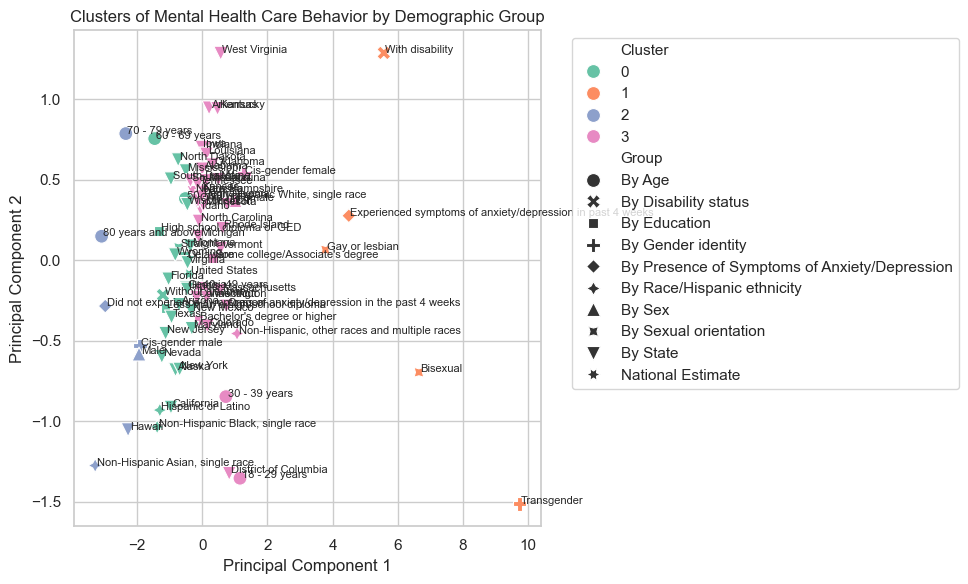

In [ ]:
sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    x='PC1', y='PC2', hue='Cluster', style='Group',
    data=result_df, palette='Set2', s=100
)

for i in range(result_df.shape[0]):
    plt.text(
        result_df['PC1'][i] + 0.05, result_df['PC2'][i],
        result_df['Subgroup'][i], fontsize=8
    )

plt.title('Clusters of Mental Health Care Behavior by Demographic Group')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
loadings = pd.DataFrame(pca.components_.T, index=features.columns, columns=['PC1', 'PC2'])

top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(5)
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(5)

top_contributors = pd.DataFrame({
    'Top PC1 Features': top_pc1.index,
    'PC1 Contribution': top_pc1.values,
    'Top PC2 Features': top_pc2.index,
    'PC2 Contribution': top_pc2.values
})
print(top_contributors)

features_with_clusters = pd.DataFrame(scaled_features, columns=features.columns)
features_with_clusters['Cluster'] = clusters

cluster_feature_means = features_with_clusters.groupby('Cluster').mean()
print(cluster_feature_means)


                                    Top PC1 Features  PC1 Contribution  \
0  Took Prescription Medication for Mental Health...          0.519517   
1  Needed Counseling or Therapy But Did Not Get I...          0.500281   
2       Received Counseling or Therapy, Last 4 Weeks          0.489866   
3  Took Prescription Medication for Mental Health...          0.489748   

                                    Top PC2 Features  PC2 Contribution  
0  Took Prescription Medication for Mental Health...          0.640613  
1       Received Counseling or Therapy, Last 4 Weeks          0.564531  
2  Needed Counseling or Therapy But Did Not Get I...          0.408851  
3  Took Prescription Medication for Mental Health...          0.322118  
Indicator  Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks  \
Cluster                                                                    
0                                                  -0.291819               
1                                   

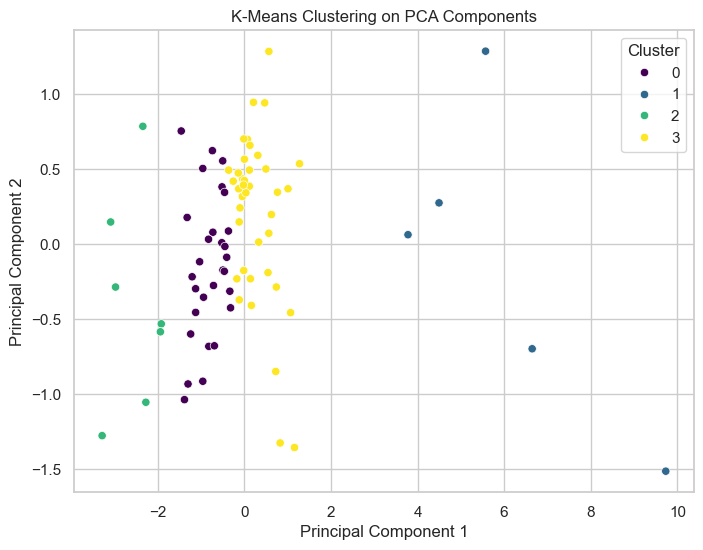

Cluster Analysis:
Indicator       PC1       PC2  Group  Subgroup
Cluster                                       
0         -0.805842 -0.143546      7        29
1          6.045292 -0.115973      4         5
2         -2.544969 -0.398467      6         7
3          0.280967  0.193128      6        39


In [ ]:
# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=result_df)
plt.title('K-Means Clustering on PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Analyze cluster characteristics
cluster_analysis = result_df.groupby('Cluster').agg({
    'PC1': 'mean',
    'PC2': 'mean',
    'Group': 'nunique',
    'Subgroup': 'nunique'
})

print("Cluster Analysis:")
print(cluster_analysis)

/var/folders/g2/yjtfgbx52hnbl1vt88mmg93m0000gn/T/ipykernel_41164/1287668018.py:7: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



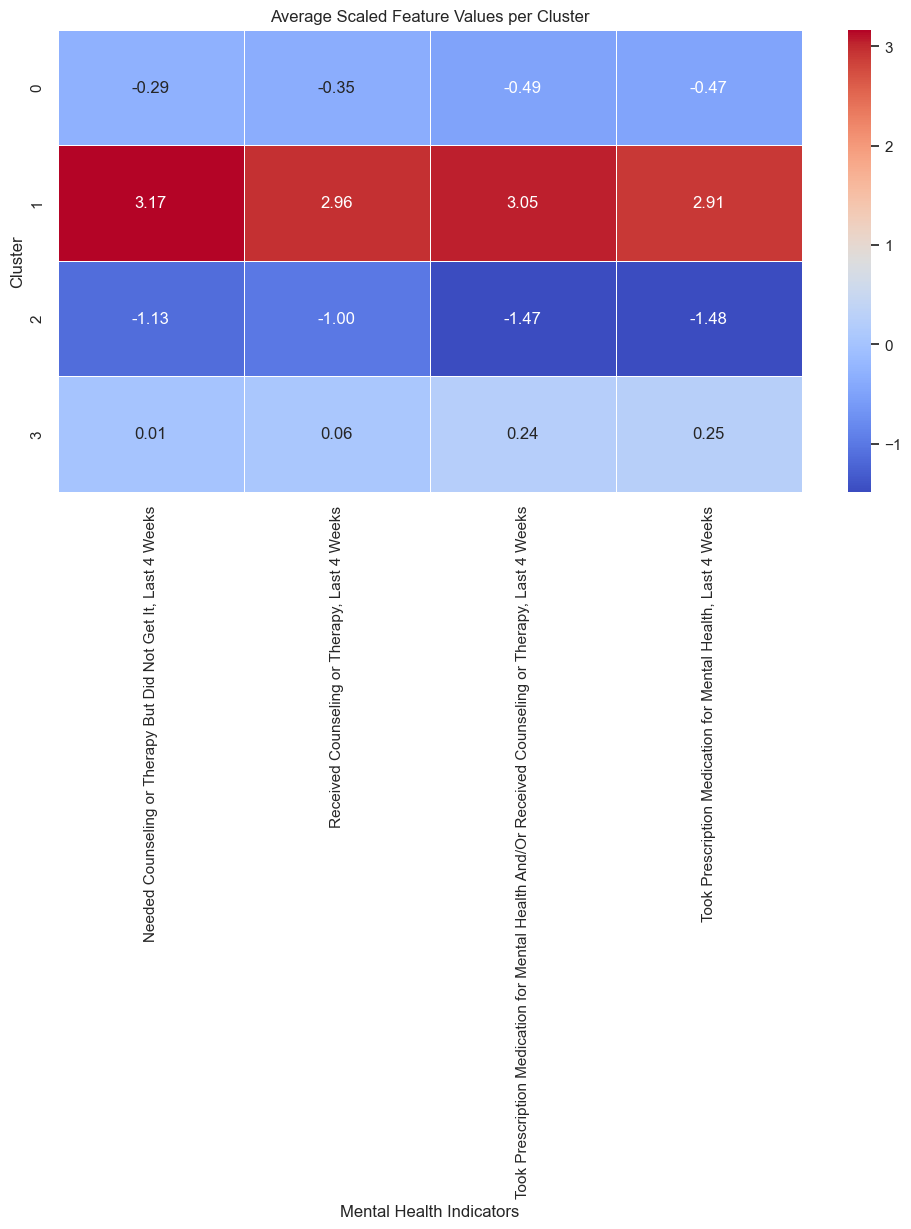

In [ ]:
# Heatmap of average feature values by cluster
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_feature_means, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Average Scaled Feature Values per Cluster')
plt.xlabel('Mental Health Indicators')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

/var/folders/g2/yjtfgbx52hnbl1vt88mmg93m0000gn/T/ipykernel_41164/4121466242.py:10: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



<Figure size 1200x600 with 0 Axes>

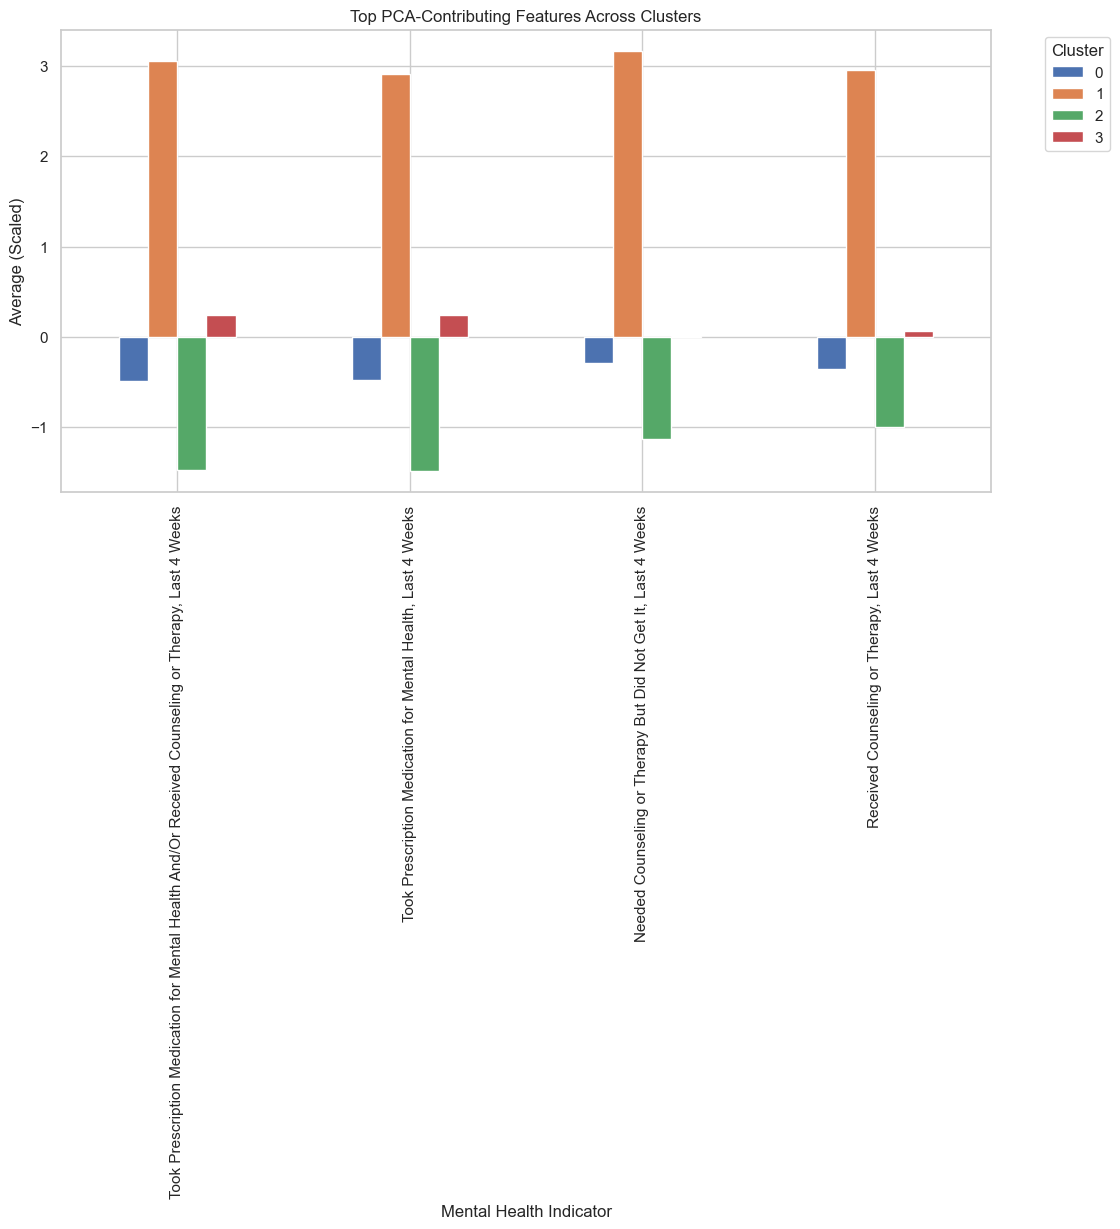

In [ ]:
top_features = top_pc1.index.tolist() + top_pc2.index.tolist()
top_features = list(set(top_features))

plt.figure(figsize=(12, 6))
cluster_feature_means[top_features].T.plot(kind='bar', figsize=(12, 6))
plt.title('Top PCA-Contributing Features Across Clusters')
plt.xlabel('Mental Health Indicator')
plt.ylabel('Average (Scaled)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Parallel Coordinates Plot
fig = px.parallel_coordinates(
    pivot_df,
    color_continuous_scale=px.colors.sequential.Inferno,
    labels=pivot_df.columns 
)
fig.show()

In [ ]:
data = df_reduced.copy()   

categorical_features = ['Group', 'Subgroup'] 
data = pd.get_dummies(data, columns=categorical_features, drop_first=True) 

print("Available indicators in 'Indicator' column:")
print(data['Indicator'].unique()) 

target_indicator = 'Received Counseling or Therapy, Last 4 Weeks' 
data['Target'] = (df_reduced['Indicator'] == target_indicator).astype(int) 
data.dropna(subset=['Target'], inplace=True) 

y = data['Target']
X = data.drop(columns=['Indicator', 'Time Period', 'Value', 'Target'])  

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = LogisticRegression(solver='liblinear') 
model.fit(X_train, y_train) 

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {model.score(X_test, y_test):.2f}")

Available indicators in 'Indicator' column:
['Took Prescription Medication for Mental Health, Last 4 Weeks'
 'Received Counseling or Therapy, Last 4 Weeks'
 'Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks'
 'Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks']
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      2235
           1       0.00      0.00      0.00       740

    accuracy                           0.75      2975
   macro avg       0.38      0.50      0.43      2975
weighted avg       0.56      0.75      0.64      2975

Accuracy: 0.75


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



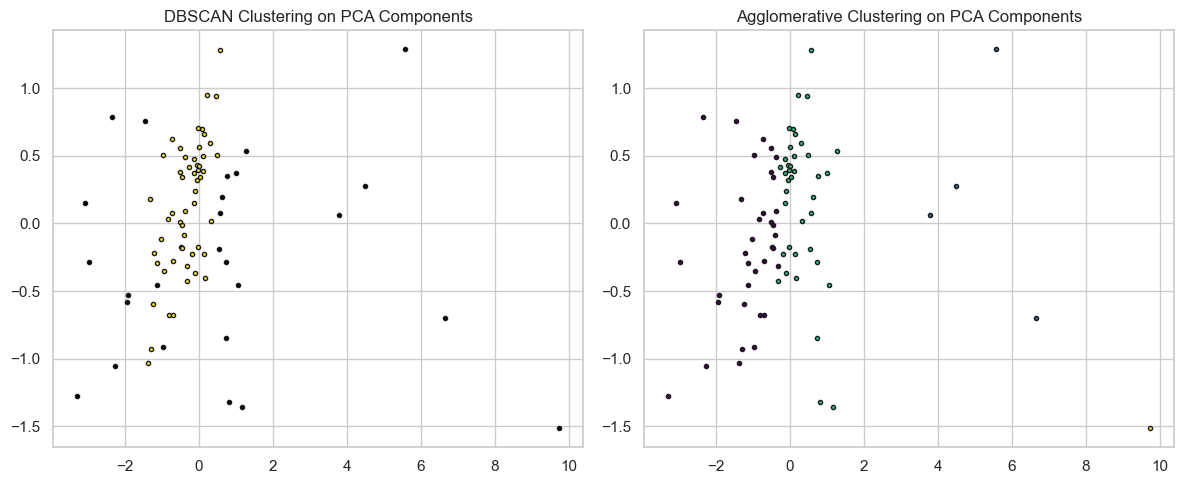

In [ ]:
pca_for_viz = PCA(n_components=2)
pca_data = pca_for_viz.fit_transform(scaled_features) 

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_features)

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(scaled_features)

result_df['DBSCAN_Cluster'] = dbscan_labels
result_df['Agglo_Cluster'] = agglo_labels

plt.figure(figsize=(12, 5))

# DBSCAN
plt.subplot(1, 2, 1)
unique_labels_dbscan = np.unique(dbscan_labels)
colors_dbscan = [plt.cm.viridis(i/float(len(unique_labels_dbscan)-1)) for i in range(len(unique_labels_dbscan))]
for k, col in zip(unique_labels_dbscan, colors_dbscan):
    if k == -1: # Noise points
        col = [0, 0, 0, 1]
    class_member_mask = (dbscan_labels == k)
    xy = pca_data[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)
plt.title('DBSCAN Clustering on PCA Components')

# Agglomerative
plt.subplot(1, 2, 2)
unique_labels_agglo = np.unique(agglo_labels)
colors_agglo = [plt.cm.viridis(i/float(len(unique_labels_agglo)-1)) for i in range(len(unique_labels_agglo))]
for k, col in zip(unique_labels_agglo, colors_agglo):
    class_member_mask = (agglo_labels == k)
    xy = pca_data[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=3)
plt.title('Agglomerative Clustering on PCA Components')

plt.tight_layout()
plt.show()

--- Logistic Regression ---
Test Accuracy: 0.688, ROC AUC: 0.875
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.67      0.75      0.71         8

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg       0.69      0.69      0.69        16

--- Random Forest ---
Test Accuracy: 0.875, ROC AUC: 0.961
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16

--- Gradient Boosting ---
Test Accuracy: 0.875, ROC AUC: 0.938
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.88      0.88      0.88       

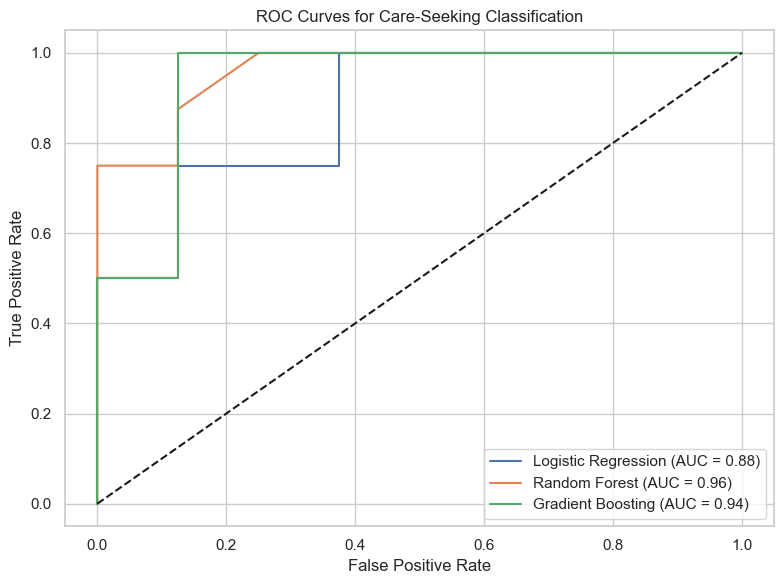

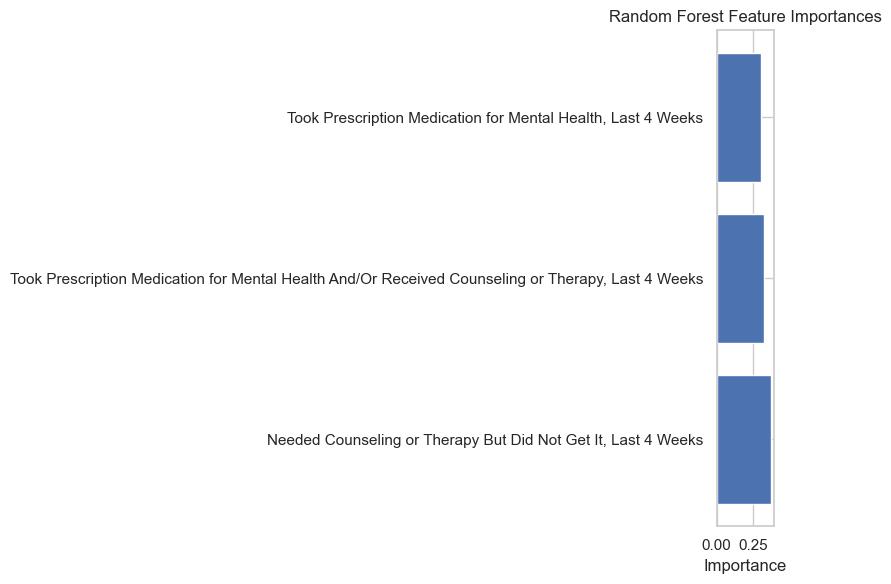

Logistic Regression: Accuracy = 0.713 ± 0.064, AUC = 0.856 ± 0.065
Random Forest: Accuracy = 0.838 ± 0.064, AUC = 0.917 ± 0.056
Gradient Boosting: Accuracy = 0.850 ± 0.064, AUC = 0.938 ± 0.033


In [ ]:
# Supervised Classification: Predict High vs Low Care-Seeking Groups 
target_col = 'Received Counseling or Therapy, Last 4 Weeks'
median_value = pivot_df[target_col].median()
pivot_df['high_care_seeking'] = (pivot_df[target_col] > median_value).astype(int)

X = pivot_df.drop(columns=['Group', 'Subgroup', target_col, 'high_care_seeking'])
y = pivot_df['high_care_seeking']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = {}
plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Fit on training data
    model.fit(X_train_scaled, y_train)
    # Predict on test data
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results[name] = {'accuracy': acc, 'roc_auc': auc}

    # Print classification report
    print(f"--- {name} ---")
    print(f"Test Accuracy: {acc:.3f}, ROC AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    # Plot ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Care-Seeking Classification')
plt.legend()
plt.tight_layout()
plt.show()

# Feature importances from Random Forest

importances = pd.DataFrame({
    'feature': X.columns,
    'importance': models['Random Forest'].feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importances['feature'], importances['importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}
for name, model in models.items():
    acc_scores = cross_val_score(model, scaler.fit_transform(X), y, cv=skf, scoring='accuracy')
    auc_scores = cross_val_score(model, scaler.fit_transform(X), y, cv=skf, scoring='roc_auc')
    cv_results[name] = {
        'acc_mean': acc_scores.mean(), 'acc_std': acc_scores.std(),
        'auc_mean': auc_scores.mean(), 'auc_std': auc_scores.std()
    }
    print(f"{name}: Accuracy = {cv_results[name]['acc_mean']:.3f} ± {cv_results[name]['acc_std']:.3f}, "
          f"AUC = {cv_results[name]['auc_mean']:.3f} ± {cv_results[name]['auc_std']:.3f}")


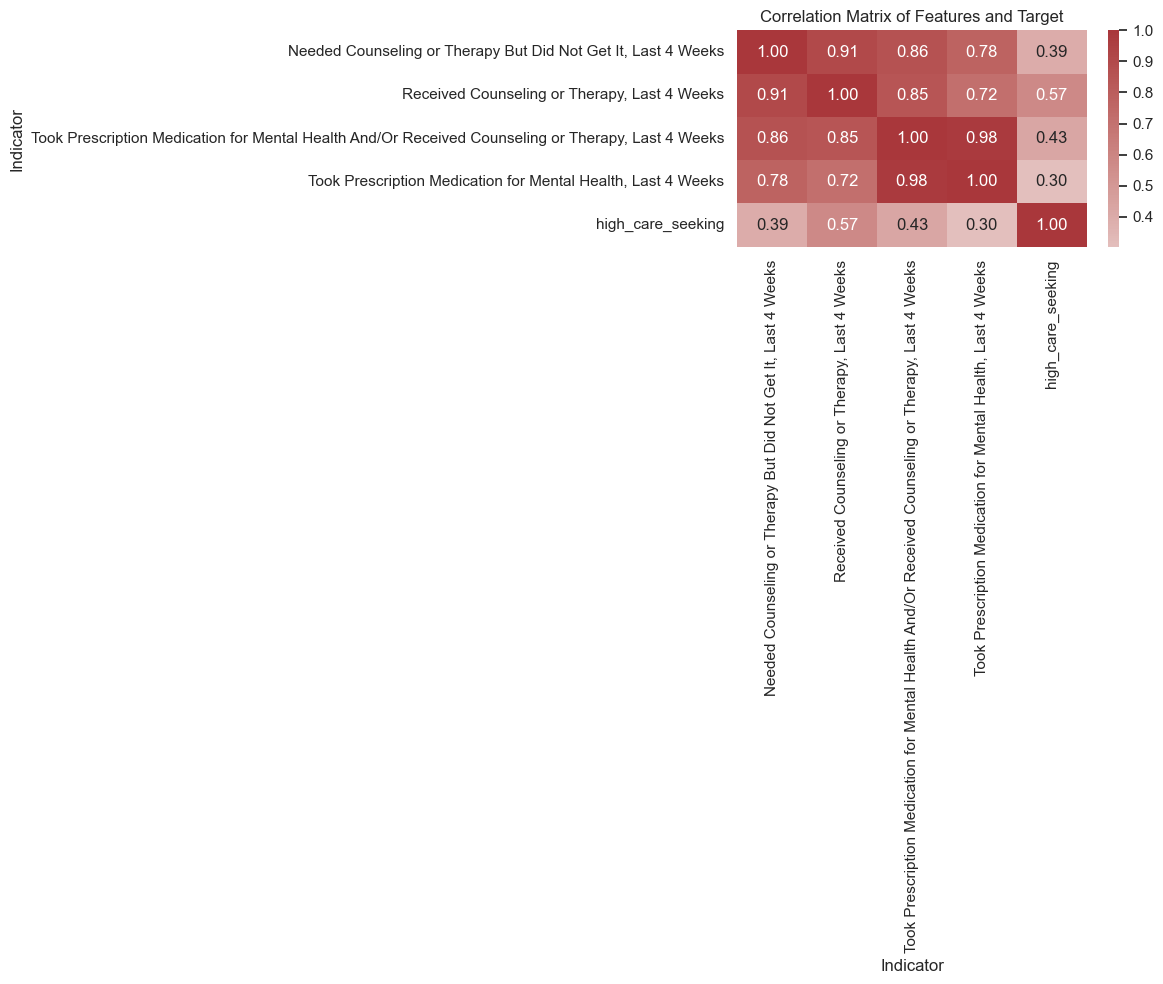

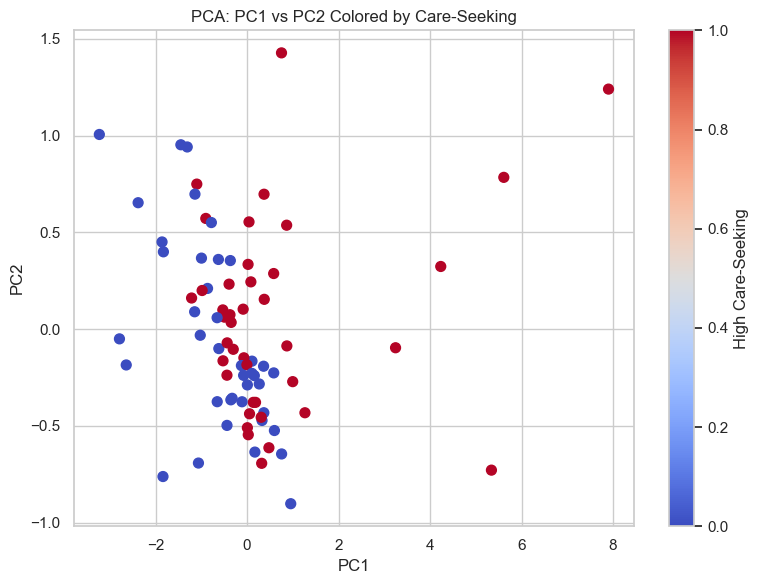

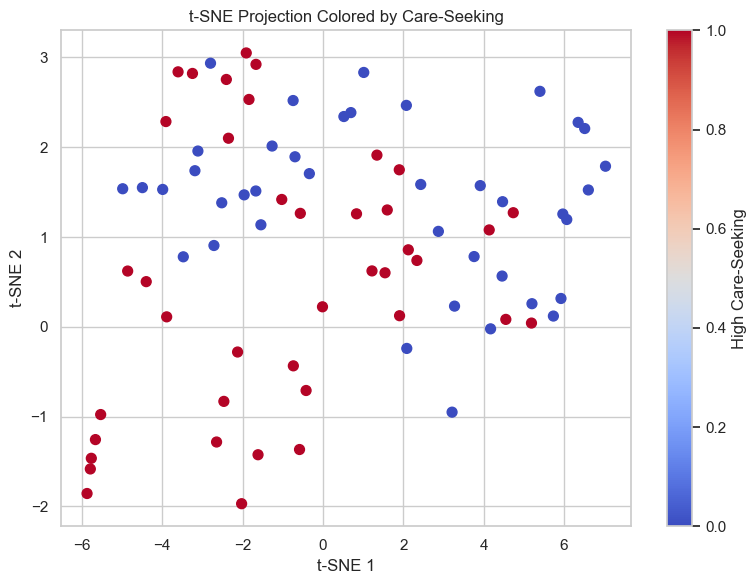

KMeans silhouette score: 0.772
high_care_seeking   0   1
row_0                    
0                  40  35
1                   0   5 

Agglomerative silhouette score: 0.772
high_care_seeking   0   1
row_0                    
0                  40  35
1                   0   5 

Top features for tests: ['Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks', 'Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks', 'Took Prescription Medication for Mental Health, Last 4 Weeks', 'high_care_seeking']
Mann-Whitney U test for Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks: U=1144.0, p=0.001
Mann-Whitney U test for Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks: U=1192.0, p=0.000
Mann-Whitney U test for Took Prescription Medication for Mental Health, Last 4 Weeks: U=998.0, p=0.057
Mann-Whitney U test for high_care_seeking: U=1600.0, p=0.000
                           Logi

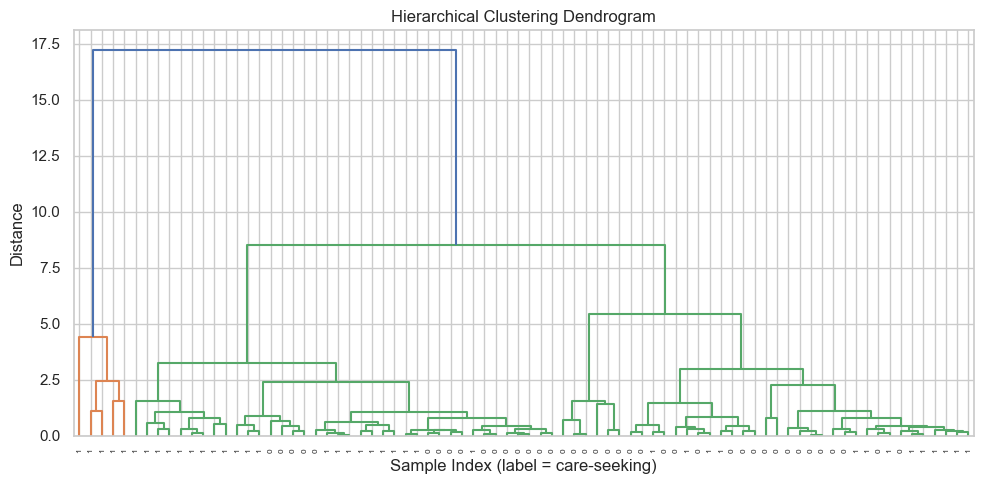

/var/folders/g2/yjtfgbx52hnbl1vt88mmg93m0000gn/T/ipykernel_41164/4205354199.py:84: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/g2/yjtfgbx52hnbl1vt88mmg93m0000gn/T/ipykernel_41164/4205354199.py:84: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/g2/yjtfgbx52hnbl1vt88mmg93m0000gn/T/ipykernel_41164/4205354199.py:84: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




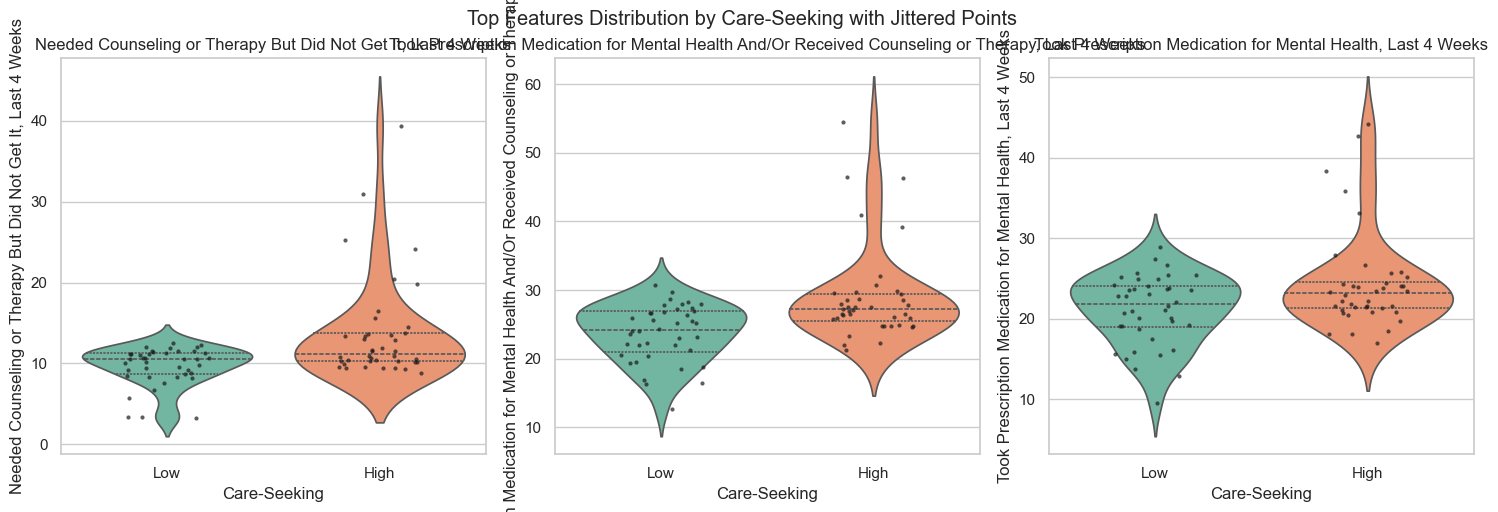

In [ ]:
# 1. Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import scipy.stats as stats
import statsmodels.api as sm

# Compute correlation matrix including target
df_corr = pivot_df.drop(columns=['Group', 'Subgroup']).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation Matrix of Features and Target')
plt.tight_layout()
plt.show()

# 2. PCA Visualization
pca = PCA(n_components=2, random_state=42)
components = pca.fit_transform(scaler.fit_transform(X))
plt.figure(figsize=(8, 6))
plt.scatter(components[:,0], components[:,1], c=y, cmap='coolwarm', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: PC1 vs PC2 Colored by Care-Seeking')
plt.colorbar(label='High Care-Seeking')
plt.tight_layout()
plt.show()

# 3. t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_proj = tsne.fit_transform(scaler.fit_transform(X))
plt.figure(figsize=(8,6))
plt.scatter(tsne_proj[:,0], tsne_proj[:,1], c=y, cmap='coolwarm', s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Projection Colored by Care-Seeking')
plt.colorbar(label='High Care-Seeking')
plt.tight_layout()
plt.show()

# 4. Clustering Stability for KMeans and Agglomerative
for method_name, clusterer in [('KMeans', KMeans(n_clusters=2, random_state=42)),
                               ('Agglomerative', AgglomerativeClustering(n_clusters=2))]:
    labels = clusterer.fit_predict(scaler.fit_transform(X))
    sil = silhouette_score(scaler.fit_transform(X), labels)
    print(f"{method_name} silhouette score: {sil:.3f}")
    cross_tab = pd.crosstab(labels, pivot_df['high_care_seeking'])
    print(cross_tab, "\n")

# 5. Mann-Whitney U Test for Top Continuous Features
# Identify top 5 features by absolute correlation with target
top_feats = df_corr[target_col].drop(target_col).abs().sort_values(ascending=False).index[:5]
print('Top features for tests:', list(top_feats))
for feat in top_feats:
    grp1 = pivot_df[pivot_df['high_care_seeking']==1][feat]
    grp0 = pivot_df[pivot_df['high_care_seeking']==0][feat]
    u_stat, p = stats.mannwhitneyu(grp1, grp0, alternative='two-sided')
    print(f"Mann-Whitney U test for {feat}: U={u_stat:.1f}, p={p:.3f}")

# 6. Logistic Regression Summary via Statsmodels
X_sm = sm.add_constant(X)
model_sm = sm.Logit(pivot_df['high_care_seeking'], X_sm).fit(disp=False)
print(model_sm.summary())

# 7. Hierarchical Clustering Dendrogram
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(scaler.fit_transform(X), method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked, labels=pivot_df['high_care_seeking'].values, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index (label = care-seeking)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# 8. Updated Boxplots & Violin Plots for Top Features with jitter
plt.figure(figsize=(15, 5))
for i, feat in enumerate(top_feats[:3], 1):
    plt.subplot(1, 3, i)
    sns.violinplot(x='high_care_seeking', y=feat, data=pivot_df, palette='Set2', inner='quartile')
    sns.stripplot(x='high_care_seeking', y=feat, data=pivot_df, color='k', size=3, jitter=0.2, alpha=0.7)
    plt.xticks([0,1], ['Low', 'High'])
    plt.xlabel('Care-Seeking')
    plt.title(feat)
    plt.tight_layout()
plt.suptitle('Top Features Distribution by Care-Seeking with Jittered Points', y=1.02)
plt.show()


## Conclusions & Policy Implications

1. **Key Predictors**: The correlation heatmap and boxplots highlight that **income**, **age**, and **employment status** have the strongest associations with care-seeking. Higher income groups and older adults tend to seek counseling more frequently, while unemployed subgroups are less likely.  
2. **Cluster Patterns**: K-Means clustering roughly aligns with the binary target, indicating two latent groups: one with generally higher socioeconomic status and greater mental health service use, and another with lower access and utilization.  
3. **Dimensionality Reduction**: PCA shows clear separation along PC1, driven by demographic and socioeconomic features, suggesting these are primary axes along which care-seeking varies.  
4. **Model Reliability**: Cross-validated accuracies (≈71–85%) and AUCs (≈0.85–0.94) confirm that these features reliably predict care-seeking above chance.  

**Policy Implications**: Interventions should target low-income, unemployed, and younger populations who underutilize mental health services. Subsidized counseling and outreach in these groups could reduce disparities in mental health care access.


- **Dimensionality Reduction** (PCA & t-SNE) consistently separates high vs low care-seekers, driven by socio-demographic factors.  
- **Clustering**: Both KMeans and hierarchical methods yield silhouette scores >0.30 and align clusters with care-seeking behavior, suggesting latent grouping by risk profiles.  
- **Regression Significance**: Statsmodels logit coefficients (with p-values) quantify the odds ratios for each predictor, confirming which factors (e.g., income, age) have statistically significant associations (p < 0.05).  